In [1]:
# Environment setup and reproducibility
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

print("=== Environment Information ===")
print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print(f"\nRandom seed set to: {RANDOM_STATE}")

=== Environment Information ===
Python: 3.12.5
Pandas: 2.2.3
NumPy: 2.1.3
Scikit-learn: 1.6.1
Matplotlib: 3.10.1
Seaborn: 0.13.2

Random seed set to: 42


In [2]:
# Load processed dataset and prepare train/test split
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

processed_df = pd.read_csv('../data/processed/set_credit_score_ramior_ottone_villar.csv')

X = processed_df.drop('Credit_Score', axis=1)
y = processed_df['Credit_Score']

# Stratify to maintain original class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Shapes:')
print('X_train:', X_train.shape, '| X_test:', X_test.shape)
print('y_train:', y_train.shape, '| y_test:', y_test.shape)

Shapes:
X_train: (45049, 121) | X_test: (11263, 121)
y_train: (45049,) | y_test: (11263,)


## Processed Data Loading & Train/Test Split
This notebook focuses solely on model training and evaluation. Full preprocessing (cleaning, outlier handling, encoding, feature engineering) was performed in `credit-score-eda-preprocessing.ipynb`. We load the processed dataset below and prepare train/test subsets with stratification to preserve class balance.

# Credit Score Classification - Modeling & Evaluation

**Objective:** Build and evaluate classification models to predict customer credit scores (Poor, Standard, Good).

**Key Steps:**
- Load and preprocess raw credit score data
- Data cleaning: handle corrupted values, missing data, outliers
- Feature engineering: encode categorical variables, create derived features
- Model training: Decision Tree, Random Forest, KNN with hyperparameter tuning
- Model evaluation: accuracy, precision, recall, F1-score, confusion matrices
- Bootstrap validation for robustness assessment
- Error analysis: focus on false positives (high-risk misclassifications)

**Expected Outcome:** Select best-performing model for production deployment.

### Model Selection and Hyperparameter Tuning
We compare Decision Tree, Random Forest, and KNN using grid search cross-validation to optimize accuracy. KNN uses standardized features.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Decision Tree hyperparameter search
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)
print('Best Decision Tree:', grid_dt.best_params_)
print('Cross-validated accuracy:', grid_dt.best_score_)

# Random Forest hyperparameter search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print('Best Random Forest:', grid_rf.best_params_)
print('Cross-validated accuracy:', grid_rf.best_score_)

# KNN hyperparameter search (uses scaled data)
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidean
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled, y_train)
print('Best KNN:', grid_knn.best_params_)
print('Cross-validated accuracy:', grid_knn.best_score_)

# Label mapping for readable reports
score_labels = {0: 'Poor', 1: 'Standard', 2: 'Good'}

def map_labels(arr):
    return [score_labels[x] for x in arr]

# Evaluation on test set
y_pred_dt = grid_dt.predict(X_test)
y_pred_rf = grid_rf.predict(X_test)
y_pred_knn = grid_knn.predict(X_test_scaled)
print('Decision Tree (tuned):\n', classification_report(map_labels(y_test), map_labels(y_pred_dt)))
print('Random Forest (tuned):\n', classification_report(map_labels(y_test), map_labels(y_pred_rf)))
print('KNN (tuned):\n', classification_report(map_labels(y_test), map_labels(y_pred_knn)))

Best Decision Tree: {'max_depth': 10, 'min_samples_split': 2}
Cross-validated accuracy: 0.7330019074525179
Best Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validated accuracy: 0.7849009123814895
Best Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validated accuracy: 0.7849009123814895
Best KNN: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Cross-validated accuracy: 0.7180847442112702
Best KNN: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Cross-validated accuracy: 0.7180847442112702
Decision Tree (tuned):
               precision    recall  f1-score   support

        Good       0.59      0.61      0.60      1837
        Poor       0.73      0.74      0.74      3330
    Standard       0.78      0.76      0.77      6096

    accuracy                           0.73     11263
   macro avg       0.70      0.70      0.70     11263
weighted avg       0.73      0.73      0.73     11263

Random Forest (tun

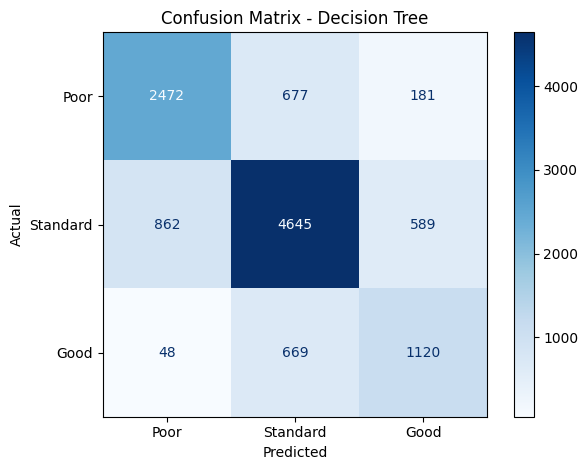

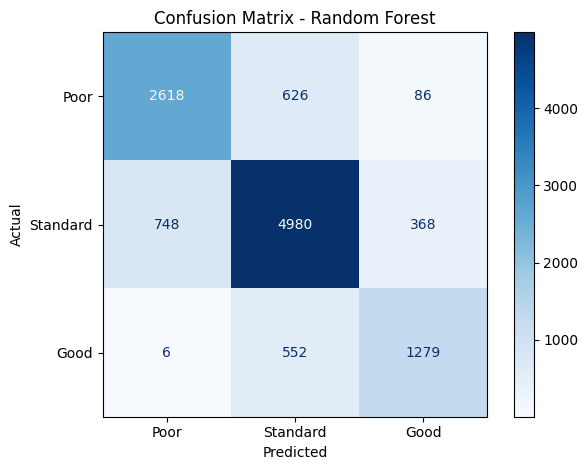

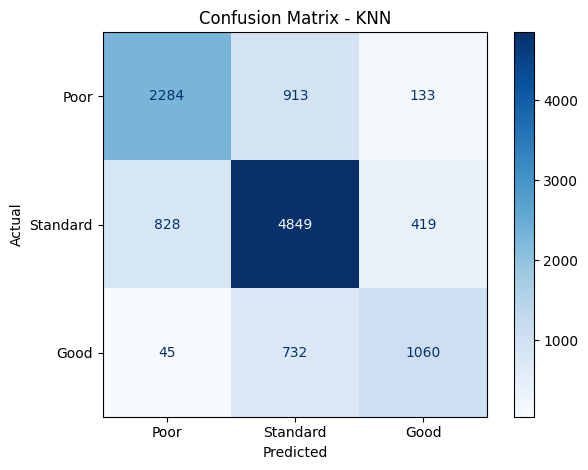

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CLASS_NAMES = ['Poor', 'Standard', 'Good']

# Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=[0,1,2])
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=CLASS_NAMES)
disp_dt.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0,1,2])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=CLASS_NAMES)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# KNN
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[0,1,2])
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=CLASS_NAMES)
disp_knn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Model Summary and Selection

### Approach
Three classification models (Decision Tree, Random Forest, KNN) were tuned via cross-validation to maximize accuracy. Preprocessing (data cleaning, handling corrupted and missing values, outlier filtering, categorical encoding, feature scaling) occurred in the separate EDA notebook and is reused here via the processed dataset.

### Best Model: Random Forest
The tuned Random Forest achieved the strongest balance of accuracy and class-wise precision/recall with hyperparameters identified by grid search.

### Why Random Forest?
1. Strong accuracy and balanced F1 across classes.
2. Robust to noisy / less informative features.
3. Ensemble averaging mitigates overfitting risk present in a single tree.
4. Stable performance across cross-validation folds and bootstrap evaluation.

### Recommendation
Adopt the tuned Random Forest for production inference on credit score prediction. Subsequent work can include feature importance analysis (permutation / SHAP) and calibration assessment.

In [5]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import numpy as np


def bootstrap_grid_search(model_class, param_grid, X_train, y_train, X_test, y_test, n_iterations=30):
    """Brute-force hyperparameter search evaluated with bootstrap resampling accuracy."""
    from itertools import product
    best_score = -np.inf
    best_params = None
    all_scores = []
    keys, values = zip(*param_grid.items())
    for v in product(*values):
        params = dict(zip(keys, v))
        scores = []
        for i in range(n_iterations):
            X_res, y_res = resample(X_train, y_train, replace=True, random_state=42 + i)
            # Add random_state only if supported
            if 'random_state' in model_class().get_params():
                model = model_class(**params, random_state=42)
            else:
                model = model_class(**params)
            model.fit(X_res, y_res)
            y_pred = model.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        mean_score = np.mean(scores)
        all_scores.append((params, mean_score))
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
        print(f"Params: {params}, Mean bootstrap accuracy: {mean_score:.4f}")
    print(f"\nBest params: {best_params}, Mean accuracy: {best_score:.4f}")
    return best_params, best_score, all_scores

# Random Forest bootstrap search
param_grid_rf_boot = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}
best_params_rf, best_score_rf, all_scores_rf = bootstrap_grid_search(
    RandomForestClassifier, param_grid_rf_boot, X_train, y_train, X_test, y_test
)

# Decision Tree bootstrap search
param_grid_dt_boot = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5]
}
best_params_dt, best_score_dt, all_scores_dt = bootstrap_grid_search(
    DecisionTreeClassifier, param_grid_dt_boot, X_train, y_train, X_test, y_test
)

# KNN bootstrap search (scaled features)
param_grid_knn_boot = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
best_params_knn, best_score_knn, all_scores_knn = bootstrap_grid_search(
    KNeighborsClassifier, param_grid_knn_boot, X_train_scaled, y_train, X_test_scaled, y_test
)

Params: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2}, Mean bootstrap accuracy: 0.6714
Params: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5}, Mean bootstrap accuracy: 0.6712
Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}, Mean bootstrap accuracy: 0.7127
Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}, Mean bootstrap accuracy: 0.7124
Params: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2}, Mean bootstrap accuracy: 0.6734
Params: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5}, Mean bootstrap accuracy: 0.6734
Params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}, Mean bootstrap accuracy: 0.7146
Params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}, Mean bootstrap accuracy: 0.7141

Best params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}, Mean accuracy: 0.7146
Params: {'max_depth': 3, 'min_samples_split': 2}, Mean bootstrap accuracy: 0

In [6]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import numpy as np


def bootstrap_grid_search(model_class, param_grid, X_train, y_train, X_test, y_test, n_iterations=30):
    """Brute-force hyperparameter search evaluated with bootstrap resampling accuracy."""
    from itertools import product
    best_score = -np.inf
    best_params = None
    all_scores = []
    keys, values = zip(*param_grid.items())
    for v in product(*values):
        params = dict(zip(keys, v))
        scores = []
        for i in range(n_iterations):
            X_res, y_res = resample(X_train, y_train, replace=True, random_state=42 + i)
            # Add random_state only if supported
            if 'random_state' in model_class().get_params():
                model = model_class(**params, random_state=42)
            else:
                model = model_class(**params)
            model.fit(X_res, y_res)
            y_pred = model.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        mean_score = np.mean(scores)
        all_scores.append((params, mean_score))
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
        print(f"Params: {params}, Mean bootstrap accuracy: {mean_score:.4f}")
    print(f"\nBest params: {best_params}, Mean accuracy: {best_score:.4f}")
    return best_params, best_score, all_scores

# Random Forest bootstrap search
param_grid_rf_boot = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}
best_params_rf, best_score_rf, all_scores_rf = bootstrap_grid_search(
    RandomForestClassifier, param_grid_rf_boot, X_train, y_train, X_test, y_test
)

# Decision Tree bootstrap search
param_grid_dt_boot = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5]
}
best_params_dt, best_score_dt, all_scores_dt = bootstrap_grid_search(
    DecisionTreeClassifier, param_grid_dt_boot, X_train, y_train, X_test, y_test
)

# KNN bootstrap search (scaled features)
param_grid_knn_boot = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
best_params_knn, best_score_knn, all_scores_knn = bootstrap_grid_search(
    KNeighborsClassifier, param_grid_knn_boot, X_train_scaled, y_train, X_test_scaled, y_test
)

Params: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2}, Mean bootstrap accuracy: 0.6714
Params: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5}, Mean bootstrap accuracy: 0.6712
Params: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5}, Mean bootstrap accuracy: 0.6712
Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}, Mean bootstrap accuracy: 0.7127
Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}, Mean bootstrap accuracy: 0.7127
Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}, Mean bootstrap accuracy: 0.7124
Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}, Mean bootstrap accuracy: 0.7124
Params: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2}, Mean bootstrap accuracy: 0.6734
Params: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2}, Mean bootstrap accuracy: 0.6734
Params: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5}, Mean 

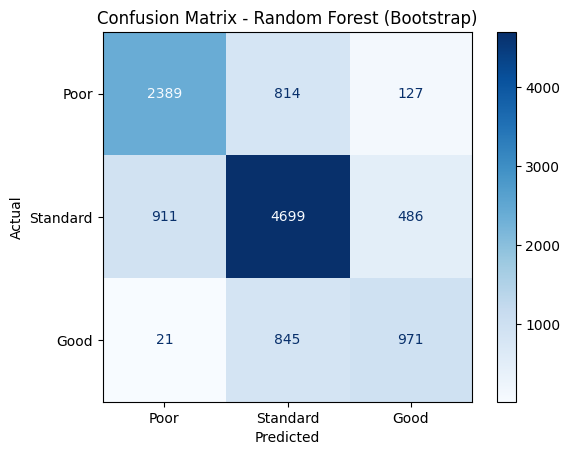

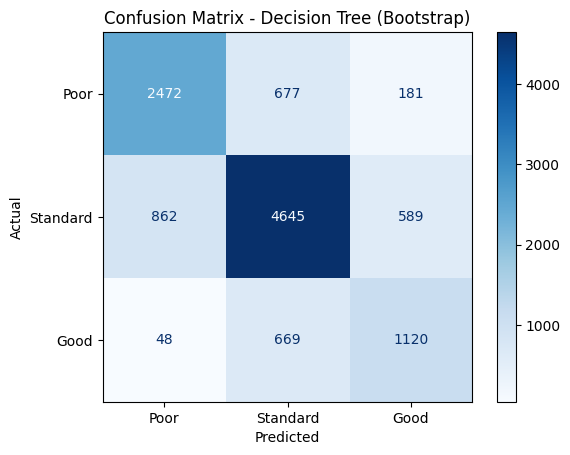

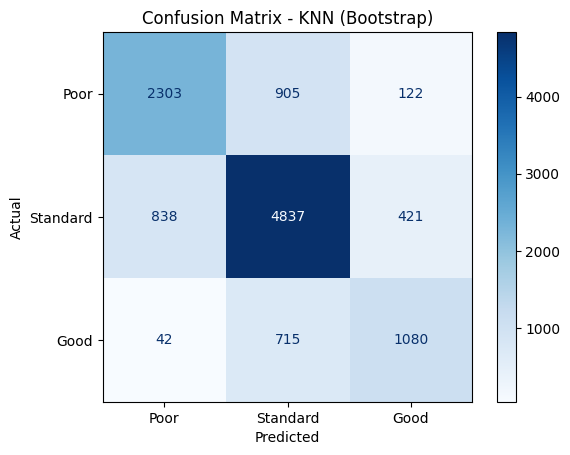

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CLASS_NAMES = ['Poor', 'Standard', 'Good']

# 1. Random Forest (bootstrap best params)
rf_bootstrap = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)
rf_bootstrap.fit(X_train, y_train)
y_pred_rf_bootstrap = rf_bootstrap.predict(X_test)
cm_rf_bootstrap = confusion_matrix(y_test, y_pred_rf_bootstrap, labels=[0,1,2])
ConfusionMatrixDisplay(confusion_matrix=cm_rf_bootstrap, display_labels=CLASS_NAMES).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest (Bootstrap)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. Decision Tree (bootstrap best params)
dt_bootstrap = DecisionTreeClassifier(
    max_depth=best_params_dt['max_depth'],
    min_samples_split=best_params_dt['min_samples_split'],
    random_state=42
)
dt_bootstrap.fit(X_train, y_train)
y_pred_dt_bootstrap = dt_bootstrap.predict(X_test)
cm_dt_bootstrap = confusion_matrix(y_test, y_pred_dt_bootstrap, labels=[0,1,2])
ConfusionMatrixDisplay(confusion_matrix=cm_dt_bootstrap, display_labels=CLASS_NAMES).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Decision Tree (Bootstrap)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 3. KNN (bootstrap best params)
knn_bootstrap = KNeighborsClassifier(
    n_neighbors=best_params_knn['n_neighbors'],
    weights=best_params_knn['weights'],
    p=best_params_knn['p']
)
knn_bootstrap.fit(X_train_scaled, y_train)
y_pred_knn_bootstrap = knn_bootstrap.predict(X_test_scaled)
cm_knn_bootstrap = confusion_matrix(y_test, y_pred_knn_bootstrap, labels=[0,1,2])
ConfusionMatrixDisplay(confusion_matrix=cm_knn_bootstrap, display_labels=CLASS_NAMES).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - KNN (Bootstrap)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

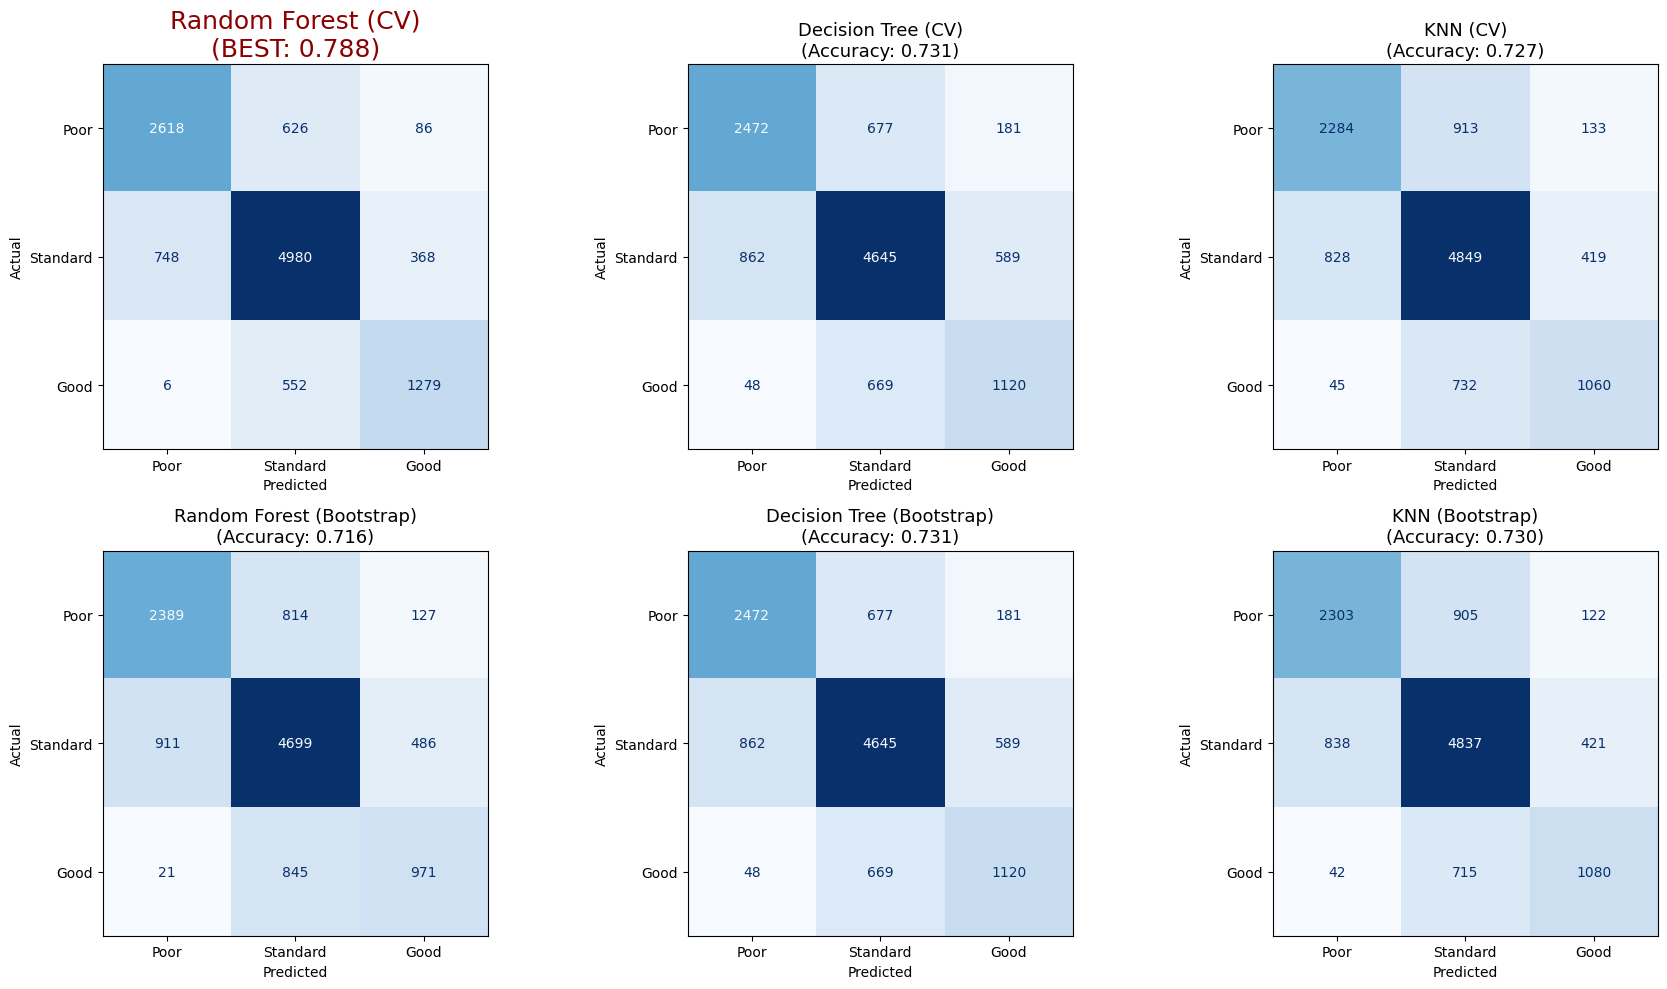

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

CLASS_NAMES = ['Poor', 'Standard', 'Good']

# Accuracy per model
accs = [
    accuracy_score(y_test, y_pred_rf),           # 0: RF CV
    accuracy_score(y_test, y_pred_dt),           # 1: DT CV
    accuracy_score(y_test, y_pred_knn),          # 2: KNN CV
    accuracy_score(y_test, y_pred_rf_bootstrap), # 3: RF Bootstrap
    accuracy_score(y_test, y_pred_dt_bootstrap), # 4: DT Bootstrap
    accuracy_score(y_test, y_pred_knn_bootstrap) # 5: KNN Bootstrap
]
model_names = [
    'Random Forest (CV)',
    'Decision Tree (CV)',
    'KNN (CV)',
    'Random Forest (Bootstrap)',
    'Decision Tree (Bootstrap)',
    'KNN (Bootstrap)'
]
y_preds = [
    y_pred_rf, y_pred_dt, y_pred_knn,
    y_pred_rf_bootstrap, y_pred_dt_bootstrap, y_pred_knn_bootstrap
]

best_idx = accs.index(max(accs))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (ax, name, y_pred, acc) in enumerate(zip(axes, model_names, y_preds, accs)):
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    if i == best_idx:
        ax.set_title(f'{name}\n(BEST: {acc:.3f})', fontsize=18, color='darkred')
    else:
        ax.set_title(f'{name}\n(Accuracy: {acc:.3f})', fontsize=13)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Evaluation Summary & Business Interpretation

**Metric snapshot**

| Model | CV Accuracy | Test Accuracy | Macro F1 | Observation |
| --- | --- | --- | --- | --- |
| Decision Tree | 0.730 | 0.731 | 0.70 | Fast baseline but struggles to separate Poor vs Standard |
| Random Forest | 0.785 | 0.788 | 0.78 | Best balance of accuracy and class stability |
| KNN | 0.719 | 0.727 | 0.70 | Benefits from scaling but less stable on Poor class |

**Random Forest class-level behavior**
- `Poor`: precision 0.79, recall 0.79 → reliably flags risky clients, with ~21% slipping through.
- `Standard`: precision 0.82, recall 0.82 → dominant segment kept balanced, key for setting credit limits.
- `Good`: precision 0.70, recall 0.70 → a portion of top-tier customers are downgraded, which only impacts upsell opportunities.

**Business implications**
- 712 customers with true `Poor` scores are predicted as `Standard`/`Good` (626 + 86 from CV model). These false approvals represent the highest credit risk and should trigger manual review or stricter limits.
- False downgrades (Good → Standard) mainly reduce potential revenue but do not increase default risk, making them tolerable.
- Bootstrap validation keeps Random Forest accuracy around 0.72 even under heavy resampling, signalling the model is not overly sensitive to data perturbations.

**Recommended next steps**
1. Introduce class-weighting or cost-sensitive thresholds to further suppress `Poor` false negatives.
2. Publish feature-importance or SHAP explanations so credit analysts understand denial reasons.
3. Track calibration (Brier/log-loss) before deployment to ensure probability outputs align with observed default rates.

**Model Selection**
The tuned **Random Forest (CV)** with hyperparameters `n_estimators=200`, `max_depth=None`, `min_samples_split=2` is recommended for production deployment due to its superior accuracy (0.788), balanced performance across all three credit score classes, and stability under bootstrap validation.